In [13]:
#%pylab inline
from scipy.optimize import curve_fit
from numpy import *
import matplotlib.pyplot as plt
import numpy as np

In [14]:
gamma = 66.0e-3 #N/m
kBT = 1.38066E-23*300*1e18 #nN.nm
eta = 0.00037# Pa.s

def splitLine(line):
    val = line.strip().split(' ')
    aux = []
    for v in val:
        if v!='':
            aux.append(float(v))
    return array(aux)

def importData(name):
    f  =open(name,'r')
    lines = f.readlines()
    f.close()    
    dat = []
    for line in lines:
        try:
            v = splitLine(line)
            dat.append(v)
        except:
            pass
    return array(dat)

def fmkt(th,k0,lamb,th0):
    U = 2*k0*lamb*sinh(lamb**2*gamma*(cos(th0*pi/180)-cos(th*pi/180))/(2*kBT))
    return U

def thFromMKT(U, k0,lamb,th0):
    return arccos(cos(th0*pi/180)-2*kBT*arcsinh(U/(2*k0*lamb))/(lamb**2*gamma))*180/pi

def fitMKT(th, U, k0,lamb,th0):
    p = [k0,lamb,th0]
    param_bounds=([0,0, 0],[np.inf,np.inf,180])
    popt, pcov = curve_fit(fmkt, th, U, p0=(k0,lamb,th0), bounds=param_bounds, maxfev = 1500)
    k0, lamb, th0 = popt[0],popt[1],popt[2]
    Uf = fmkt(th,k0, lamb, th0)
    return k0,lamb,th0, Uf

def findroot(kb, lamb, th0, Ucrit):
    t = arange(0, 180,0.001)
    U = fmkt(t,k0,lamb,th0)
    y = abs(U-Ucrit)
    ic = where(y==min(y))[0][0]
    return U[ic], t[ic]
    
    

In [15]:
dat = importData('c11.dat')
# dat = importData('data.dat')
Ca, Ucl, thm, thap = dat[:,0],dat[:,1], dat[:,2], dat[:,3]
# Split receding/advance
icA, icR = Ucl>=0, Ucl<=0
UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
# Locate the critical values for which thap = 0
i = where(thap==0)[0][0]
CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]
print (CaCrit, UclCrit, thmCrit)

UclA

-0.136407988289119 -24.3322357488699 59.0156822775219


array([84.12146393, 68.67037721, 53.26946407, 48.03196681, 39.24665329,
       30.1336464 , 26.6021552 , 22.31450425, 14.07434223,  8.58366918,
        5.52426195,  3.79131094,  0.        ])

-24.331810372367528 49.550000000000004
0 19.902177852274942 0.5393497487683407 76.75419801991076 49.550000000000004 1.6935919141613698


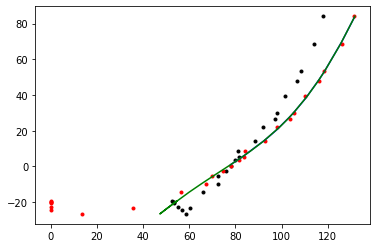

In [20]:
sk0, slamb, sth0 = 68.4, 0.71, 127.0
# MKT fitting of Ucl, thAp in the advance region
k0,lamb,th0, Uf = fitMKT(thapA, UclA, sk0,slamb,sth0)
# print r'k0 = %.4f, lamb=%.4f, th0 =%.4f'%(k0,lamb,th0)
# MKT estimation of thm in the receding region using the previous parameter
thEstim = thFromMKT(Ucl, k0,lamb,th0)

UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
CaCritm = eta*UclCritm/gamma
LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
# print CaCritm, UclCritm, thCritm, LLm
print(UclCritm, thCritm)
print (0, k0,lamb,th0, thCritm, LLm)

plt.figure()
plt.plot(thm, Ucl,'k.')
plt.plot(thap, Ucl,'r.')
plt.plot(thapA, Uf, 'b-')
plt.plot(thEstim, Ucl, 'g-')

In [22]:
((thap*pi/180)**3-9*Ca*log(LLm))**(1./3.)*180/pi

array([122.82511253, 118.2890658 , 111.87784307, 110.01613734,
       104.70565807, 100.76385169,  99.33228055,  93.96680139,
        89.99540938,  82.01504221,  82.34097491,  80.54920874,
        77.96734274,  75.40912545,  71.8115514 ,  70.81611327,
        63.0661571 ,  54.46599354,  51.34944903,  49.55028875,
        48.39005371,  46.77393564,  45.83957397,  46.5189125 ,
        46.30979382])

In [18]:
for ii in range(10):
    thm = ((thap*pi/180)**3-9*Ca*log(LLm))**(1./3.)*180/pi
    # Split receding/advance
    icA, icR = Ucl>=0, Ucl<=0
    UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
    UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
    # Locate the critical values for which thap = 0
    i = where(thap==0)[0][0]
    CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]

    # Fit MKT 
    # MKT fitting of Ucl, thm2 in the advance region
    k0,lamb,th0, Uf = fitMKT(thmA, UclA, k0,lamb,th0)
    #print r'k0 = %.2f, lamb=%.2f, th0 =%.2f'%(k0,lamb,th0)
    # MKT estimation of thm in the receding region using the previous parameter
    thEstim = thFromMKT(Ucl, k0,lamb,th0)

    #Critical receding angle for film deposition
    UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
    CaCritm = eta*UclCritm/gamma
    LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
    print (ii+1, k0,lamb,th0, thCritm, LLm)

1 21.770370855632542 0.5611320415782834 76.58638704410446 54.397 2.0078412961827823
2 21.948661671773852 0.5735599957730336 76.49799816391645 55.901 2.1307720800822767
3 21.933135815760203 0.5788277805839412 76.46288929503511 56.42 2.1765776419217553
4 21.916142761772623 0.5808497845578774 76.4497550755355 56.605000000000004 2.193354850936856
5 21.908443440795818 0.5815984907035499 76.44493788502487 56.672000000000004 2.1995214759402755
6 21.905416936805906 0.5818747808362347 76.44316637563644 56.696 2.2016906498939397
7 21.904327561865408 0.5819721084736336 76.4425432476506 56.705 2.2025629696728757
8 21.903885367076057 0.5820112707948314 76.44229255529895 56.708 2.2027958109311827
9 21.90376702735256 0.5820217260080025 76.44222566948403 56.709 2.2028960891600002
10 21.903715793074216 0.5820262299264677 76.44219680136352 56.71 2.203048200423618


# C7

In [125]:
dat = importData('c7.dat')
# dat = importData('data.dat')
Ca, Ucl, thm, thap = dat[:,0],dat[:,1], dat[:,2], dat[:,3]
# Split receding/advance
icA, icR = Ucl>=0, Ucl<=0
UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
# Locate the critical values for which thap = 0
i = where(thap==0)[0][0]
CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]
print CaCrit, UclCrit, thmCrit

-0.743939529727602 -132.702726924383 88.651226462199


0 32.94729706669271 0.6263986010739483 109.8920515072697 -0.7439226320381248 74.781 1.3938567934262613


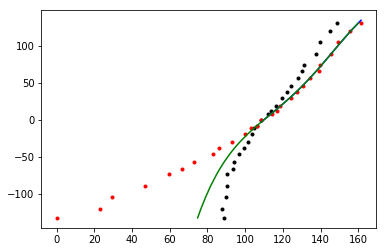

In [126]:
sk0, slamb, sth0 = 68.4, 0.71, 127.0
# MKT fitting of Ucl, thAp in the advance region
k0,lamb,th0, Uf = fitMKT(thapA, UclA, sk0,slamb,sth0)
# MKT estimation of thm in the receding region using the previous parameter
thEstim = thFromMKT(Ucl, k0,lamb,th0)

UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
CaCritm = eta*UclCritm/gamma
LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
print 0, k0,lamb,th0,CaCritm, thCritm, LLm

figure()
plot(thm, Ucl,'k.')
plot(thap, Ucl,'r.')
plot(thapA, Uf, 'b-')
plot(thEstim, Ucl, 'g-')

In [127]:
for ii in range(10):
    thm = ((thap*pi/180)**3-9*Ca*log(LLm))**(1./3.)*180/pi
    # Split receding/advance
    icA, icR = Ucl>=0, Ucl<=0
    UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
    UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
    # Locate the critical values for which thap = 0
    i = where(thap==0)[0][0]
    CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]

    # Fit MKT 
    # MKT fitting of Ucl, thm2 in the advance region
    k0,lamb,th0, Uf = fitMKT(thmA, UclA, k0,lamb,th0)
    #print r'k0 = %.2f, lamb=%.2f, th0 =%.2f'%(k0,lamb,th0)
    # MKT estimation of thm in the receding region using the previous parameter
    thEstim = thFromMKT(Ucl, k0,lamb,th0)

    #Critical receding angle for film deposition
    UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
    CaCritm = eta*UclCritm/gamma
    LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
    print ii+1, k0,lamb,th0,CaCritm, thCritm, LLm

1 49.164882301588456 0.5916499680200339 110.14026647434294 -0.7439306991213497 77.526 1.4477315547711478
2 51.661155071234944 0.5871728541986354 110.15844595071005 -0.7439498032313423 77.857 1.4546243417409446
3 51.987009298444804 0.5866008765077393 110.1605915783166 -0.7439440039682387 77.899 1.4555115355296373
4 52.02905402375319 0.5865272857552306 110.16086504074434 -0.7439584849433866 77.904 1.4556061100232887
5 52.03354641887889 0.58651941436038 110.16089399432438 -0.7439421117969465 77.905 1.4556391819908268
6 52.03511765870288 0.5865166626368673 110.16090428649703 -0.7439497936180092 77.905 1.4556335388628403
7 52.03484594134723 0.5865171422049058 110.16090250826865 -0.7439484857158944 77.905 1.4556344996485526
8 52.034897082624354 0.5865170469922908 110.16090284216588 -0.7439487045781507 77.905 1.4556343388719226
9 52.03488890028085 0.5865170620939606 110.16090281334272 -0.743948669739339 77.905 1.4556343644645724
10 52.03488804749984 0.5865170648413571 110.1609027056432 -0.743

# C8

In [128]:
dat = importData('c8.dat')
# dat = importData('data.dat')
Ca, Ucl, thm, thap = dat[:,0],dat[:,1], dat[:,2], dat[:,3]
# Split receding/advance
icA, icR = Ucl>=0, Ucl<=0
UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
# Locate the critical values for which thap = 0
i = where(thap==0)[0][0]
CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]
print CaCrit, UclCrit, thmCrit

-0.425281004468192 -75.8609359321639 78.19930059017


0 32.76343693702876 0.582985526919632 102.8819350184349 -0.4252747253278159 72.071 1.6820242683136302


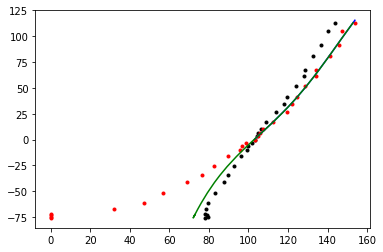

In [129]:
sk0, slamb, sth0 = 68.4, 0.71, 127.0
# MKT fitting of Ucl, thAp in the advance region
k0,lamb,th0, Uf = fitMKT(thapA, UclA, sk0,slamb,sth0)
# MKT estimation of thm in the receding region using the previous parameter
thEstim = thFromMKT(Ucl, k0,lamb,th0)

UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
CaCritm = eta*UclCritm/gamma
LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
print 0, k0,lamb,th0,CaCritm, thCritm, LLm


figure()
plot(thm, Ucl,'k.')
plot(thap, Ucl,'r.')
plot(thapA, Uf, 'b-')
plot(thEstim, Ucl, 'g-')

In [130]:
for ii in range(10):
    thm = ((thap*pi/180)**3-9*Ca*log(LLm))**(1./3.)*180/pi
    # Split receding/advance
    icA, icR = Ucl>=0, Ucl<=0
    UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
    UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
    # Locate the critical values for which thap = 0
    i = where(thap==0)[0][0]
    CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]

    # Fit MKT 
    # MKT fitting of Ucl, thm2 in the advance region
    k0,lamb,th0, Uf = fitMKT(thmA, UclA, k0,lamb,th0)
    #print r'k0 = %.2f, lamb=%.2f, th0 =%.2f'%(k0,lamb,th0)
    # MKT estimation of thm in the receding region using the previous parameter
    thEstim = thFromMKT(Ucl, k0,lamb,th0)

    #Critical receding angle for film deposition
    UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
    CaCritm = eta*UclCritm/gamma
    LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
    print ii+1, k0,lamb,th0,CaCritm, thCritm, LLm

1 52.5204018225396 0.551081297119836 102.97539619617903 -0.42527480362198566 77.066 1.8884988312164572
2 59.62288337911078 0.5417105735234065 102.97478979189518 -0.4252887620074338 78.289 1.9474326678413507
3 61.81705743716268 0.5389332467085796 102.97350094207783 -0.4252872675136591 78.622 1.9641419657310781
4 62.45495086941185 0.5381348101522622 102.97306013424152 -0.42529163578096757 78.715 1.9688446262598762
5 62.635760375996306 0.5379092409779531 102.97293018138333 -0.4252722149462573 78.742 1.9702790978503406
6 62.69106973768741 0.5378402611765517 102.97289026924435 -0.425271421999543 78.75 1.970688936564226
7 62.70687767531556 0.5378205550146844 102.97287869075006 -0.4252775855468321 78.752 1.9707714216647338
8 62.710060704206576 0.5378165864148733 102.97287636890997 -0.42528786243493394 78.752 1.9707391134313559
9 62.7088166116617 0.5378181349338133 102.97287730850718 -0.42528383909587614 78.752 1.9707517616587389
10 62.709311071095854 0.5378175122784727 102.97287702772527 -0.4

# C9

In [146]:
dat = importData('c9.dat')
# dat = importData('data.dat')
Ca, Ucl, thm, thap = dat[:,0],dat[:,1], dat[:,2], dat[:,3]
# Split receding/advance
icA, icR = Ucl>=0, Ucl<=0
UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
# Locate the critical values for which thap = 0
i = where(thap==0)[0][0]
CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]
print CaCrit, UclCrit, thmCrit

-0.321946897289302 -57.428365462416 70.2274667269891


0 40.14639096431692 0.5272015861761016 95.84399751006936 -0.3219504130690758 66.385 1.7105201424621073


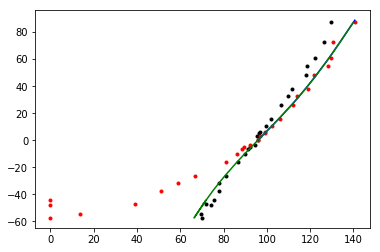

In [147]:
sk0, slamb, sth0 = 41.5, 0.55, 94.0
# MKT fitting of Ucl, thAp in the advance region
k0,lamb,th0, Uf = fitMKT(thapA, UclA, sk0,slamb,sth0)
# MKT estimation of thm in the receding region using the previous parameter
thEstim = thFromMKT(Ucl, k0,lamb,th0)

UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
CaCritm = eta*UclCritm/gamma
LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
print 0, k0,lamb,th0,CaCritm, thCritm, LLm


figure()
plot(thm, Ucl,'k.')
plot(thap, Ucl,'r.')
plot(thapA, Uf, 'b-')
plot(thEstim, Ucl, 'g-')

In [148]:
for ii in range(10):
    thm = ((thap*pi/180)**3-9*Ca*log(LLm))**(1./3.)*180/pi
    # Split receding/advance
    icA, icR = Ucl>=0, Ucl<=0
    UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
    UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
    # Locate the critical values for which thap = 0
    i = where(thap==0)[0][0]
    CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]

    # Fit MKT 
    # MKT fitting of Ucl, thm2 in the advance region
    k0,lamb,th0, Uf = fitMKT(thmA, UclA, k0,lamb,th0)
    #print r'k0 = %.2f, lamb=%.2f, th0 =%.2f'%(k0,lamb,th0)
    # MKT estimation of thm in the receding region using the previous parameter
    thEstim = thFromMKT(Ucl, k0,lamb,th0)

    #Critical receding angle for film deposition
    UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
    CaCritm = eta*UclCritm/gamma
    LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
    print ii+1, k0,lamb,th0,CaCritm, thCritm, LLm

1 66.63454455162221 0.49135129826288954 95.78856895999398 -0.3219453893673841 71.897 1.9776906671742938
2 82.16144412797583 0.47287883924197904 95.75719214285078 -0.3219542996819739 73.511 2.072745024708969
3 89.22266165861336 0.4650556143275687 95.74545546147343 -0.3219541093943897 74.046 2.1062396681365367
4 91.97844638814472 0.46209988338571356 95.74126070047295 -0.3219401917074933 74.231 2.118130640903852
5 92.99501727179582 0.46102323048239874 95.7397644721174 -0.32195418169882245 74.295 2.1221806625507913
6 93.34604506077598 0.4606531651910551 95.73925404961474 -0.32195461209893855 74.31700000000001 2.1235979571557633
7 93.46947432428405 0.46052324786002513 95.73907524783604 -0.32194967730098767 74.325 2.124139085108962
8 93.51668921069238 0.4604735763587146 95.73900702032769 -0.3219486750807682 74.328 2.1243378590191497
9 93.53402930371992 0.4604553435375494 95.73898185290875 -0.3219499803464124 74.32900000000001 2.124395974173545
10 93.53910437109545 0.4604500059920341 95.73897

# C11

In [3]:
dat = importData('c11.dat')
# dat = importData('data.dat')
Ca, Ucl, thm, thap = dat[:,0],dat[:,1], dat[:,2], dat[:,3]
# Split receding/advance
icA, icR = Ucl>=0, Ucl<=0
UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
# Locate the critical values for which thap = 0
i = where(thap==0)[0][0]
CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]
print CaCrit, UclCrit, thmCrit

-0.136407988289119 -24.3322357488699 59.0156822775219


### Fit MKT to advance considering $\theta_m\approx\theta_{app}$

0 19.902178020236285 0.5393497479884003 76.75419805585572 -0.13640560430234408 49.550000000000004 1.6935919095845595


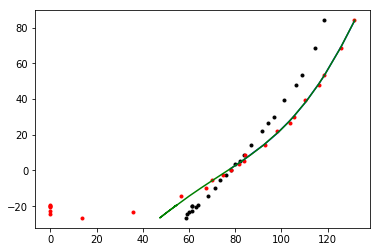

In [4]:
sk0, slamb, sth0 = 22.2995992, 0.5294434, 77.3873481
# MKT fitting of Ucl, thAp in the advance region
k0,lamb,th0, Uf = fitMKT(thapA, UclA, sk0,slamb,sth0)
# MKT estimation of thm in the receding region using the previous parameter
thEstim = thFromMKT(Ucl, k0,lamb,th0)

UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
CaCritm = eta*UclCritm/gamma
LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
print 0, k0,lamb,th0,CaCritm, thCritm, LLm

figure()
plot(thm, Ucl,'k.')
plot(thap, Ucl,'r.')
plot(thapA, Uf, 'b-')
plot(thEstim, Ucl, 'g-')

# Second iteration

In [5]:
for ii in range(10):
    thm = ((thap*pi/180)**3-9*Ca*log(LLm))**(1./3.)*180/pi
    # Split receding/advance
    icA, icR = Ucl>=0, Ucl<=0
    UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
    UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
    # Locate the critical values for which thap = 0
    i = where(thap==0)[0][0]
    CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]

    # Fit MKT 
    # MKT fitting of Ucl, thm2 in the advance region
    k0,lamb,th0, Uf = fitMKT(thmA, UclA, k0,lamb,th0)
    #print r'k0 = %.2f, lamb=%.2f, th0 =%.2f'%(k0,lamb,th0)
    # MKT estimation of thm in the receding region using the previous parameter
    thEstim = thFromMKT(Ucl, k0,lamb,th0)

    #Critical receding angle for film deposition
    UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
    CaCritm = eta*UclCritm/gamma
    LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
    print ii+1, k0,lamb,th0,CaCritm, thCritm, LLm


1 21.770370864430898 0.5611320413124786 76.58638704261692 -0.13640936153257271 54.397 2.0078412980564724
2 21.948661995066505 0.5735599943936738 76.49799822713935 -0.1364106744515186 55.901 2.130772063259392
3 21.933135862137277 0.5788277796015321 76.4628892993207 -0.13641016089099378 56.42 2.1765776478130765
4 21.916142799214366 0.5808497845954854 76.44975507579957 -0.1364096954808865 56.605000000000004 2.193354847577803
5 21.908443532464474 0.5815984902783038 76.44493792383103 -0.1364070572656532 56.672000000000004 2.1995214686158766
6 21.90541717381576 0.5818747795647756 76.44316644153218 -0.1364098475653894 56.696 2.20169063663578
7 21.904327431196606 0.5819721085011716 76.44254322322566 -0.13640635275235158 56.705 2.202562982580292
8 21.903885529572683 0.5820112706312873 76.44229258904603 -0.13640974454939211 56.708 2.202795795822685
9 21.90376694836565 0.5820217257431739 76.44222565970497 -0.13640909611832794 56.709 2.2028960993002284
10 21.903716014420265 0.5820262294565891 76.4

# C14

In [142]:
dat = importData('c14.dat')
# dat = importData('data.dat')
Ca, Ucl, thm, thap = dat[:,0],dat[:,1], dat[:,2], dat[:,3]
# Split receding/advance
icA, icR = Ucl>=0, Ucl<=0
UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
# Locate the critical values for which thap = 0
i = where(thap==0)[0][0]
CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]
print CaCrit, UclCrit, thmCrit

-0.031605572422197 -5.63775075639195 30.8216507387281


0 22.497149387292136 0.45605458239184576 45.13032113955323 -0.03160517473431538 29.625 1.6257457917943576


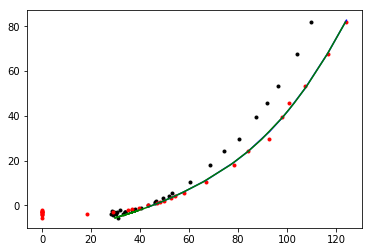

In [143]:
sk0, slamb, sth0 = 25.7, 0.48, 42.4
# MKT fitting of Ucl, thAp in the advance region
k0,lamb,th0, Uf = fitMKT(thapA, UclA, sk0,slamb,sth0)
# MKT estimation of thm in the receding region using the previous parameter
thEstim = thFromMKT(Ucl, k0,lamb,th0)

UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
CaCritm = eta*UclCritm/gamma
LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
print 0, k0,lamb,th0,CaCritm, thCritm, LLm

figure()
plot(thm, Ucl,'k.')
plot(thap, Ucl,'r.')
plot(thapA, Uf, 'b-')
plot(thEstim, Ucl, 'g-')

In [144]:
for ii in range(10):
    thm = ((thap*pi/180)**3-9*Ca*log(LLm))**(1./3.)*180/pi
    # Split receding/advance
    icA, icR = Ucl>=0, Ucl<=0
    UclA, thmA, thapA, CaA = Ucl[icA], thm[icA], thap[icA], Ca[icA]
    UclR, thmR, thapR, CaR = Ucl[icR], thm[icR], thap[icR], Ca[icR]
    # Locate the critical values for which thap = 0
    i = where(thap==0)[0][0]
    CaCrit, UclCrit, thmCrit = Ca[i], Ucl[i], thm[i]

    # Fit MKT 
    # MKT fitting of Ucl, thm2 in the advance region
    k0,lamb,th0, Uf = fitMKT(thmA, UclA, k0,lamb,th0)
    #print r'k0 = %.2f, lamb=%.2f, th0 =%.2f'%(k0,lamb,th0)
    # MKT estimation of thm in the receding region using the previous parameter
    thEstim = thFromMKT(Ucl, k0,lamb,th0)

    #Critical receding angle for film deposition
    UclCritm, thCritm = findroot(k0, lamb, th0, UclCrit)
    CaCritm = eta*UclCritm/gamma
    LLm = exp(-(thCritm*pi/180)**3/(9*CaCritm))
    print ii+1, k0,lamb,th0,CaCritm, thCritm, LLm

1 27.544733667905486 0.4578366513878358 44.75170052661261 -0.03160647723370089 32.55 1.9051574242475202
2 29.562136379449832 0.4592390652071147 44.5956095234196 -0.03160571856134973 33.407000000000004 2.0074098700595826
3 30.284130742849374 0.4597982187189817 44.54075534073955 -0.031604783435003315 33.682 2.04258740236079
4 30.531235206650383 0.4599947722219525 44.522155213990445 -0.031606073253721154 33.772 2.054286413698236
5 30.613300003433526 0.4600605531980853 44.51600022196728 -0.031605209888360346 33.802 2.058275561558442
6 30.64126458411613 0.46008304721583493 44.513904261454606 -0.0316053900511447 33.812 2.05958657511738
7 30.650454326660288 0.46009044298948487 44.51321599544698 -0.031606193034546315 33.815 2.059944914771815
8 30.652965993806006 0.46009246520986896 44.513027951171274 -0.031605936088435406 33.816 2.060089099981091
9 30.653976620350626 0.4600932787249324 44.512952232631015 -0.03160425351630611 33.817 2.0603004813037935
10 30.655458155347183 0.4600944716757869 44